# Homework 5

**Due: 05/07/2020** (Thursday 7th May at 11:59pm).

## Instructions

+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you can either:
    - Type the answer using the built-in latex capabilities. In this case, simply export the notebook as a pdf and upload it on gradescope; or
    - you can print the notebook (after you are done with all the code), write your answers by hand, scan, turn your response to a single pdf, and upload on gradescope. 



**Note**: Please match all the pages corresponding to each of the questions when you submit on gradescope. 

## Student details

+ **First Name:**
+ **Last Name:**
+ **Email:**

## Readings

Before attempting the homework, it is probably a good idea to review the slides and/or lecture handouts of lectures 19-24 (Inverse problems and Bayesian inference).

In [1]:
import numpy as np
#from autograd import numpy as anp, elementwise_grad as egrad

import theano as th
from theano import shared, function, tensor as tt
import pymc3 as pm

import math
import scipy.stats as st
import scipy

import pandas as pd
import io
import requests

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

## Problem 1  - Catalysis problem 

Recall that we used the problem of calibrating reaction rate coefficients in a catalytic reaction as the running example for demonstrating various approaches to solving inverse problems - beginning with the classical approach where this task is posed as the minimization of a misfit function, to the probabilistic approach where the inverse problem is posed as a Bayesian inference task. In this assignment, we will re-visit the catalysis problem (yet again !), this time solving it with ```pyMC```. Working through this assignment should help you get comfortable with probabilistic programming. 

In [2]:
# load the catalysis data 
catalysis_url="https://raw.githubusercontent.com/PredictiveScienceLab/uq-course/master/lectures/catalysis.csv"
s=requests.get(catalysis_url).content
catalysis_data = pd.read_csv(io.StringIO(s.decode('utf-8')))
catalysis_data

,Time,NO3,NO2,N2,NH3,N2O
0,0,500.00,0.00,0.00,0.00,0.00
1,30,250.95,107.32,18.51,3.33,4.98
2,60,123.66,132.33,74.85,7.34,20.14
3,90,84.47,98.81,166.19,13.14,42.10
4,120,30.24,38.74,249.78,19.54,55.98
5,150,27.94,10.42,292.32,24.07,60.65
6,180,13.54,6.11,309.50,27.26,62.54


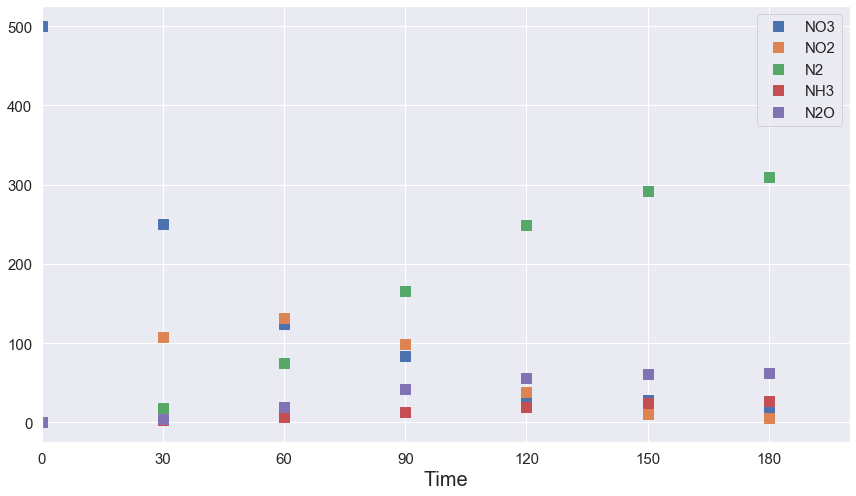

In [3]:
tickparams = {'fontsize':15, 'xticks':catalysis_data.Time.values}
markerparams = {'marker':'s', 'markersize':10}
ax=catalysis_data.plot(style='s', x=0, figsize=(12, 7), xlim=(0, 200),
                       **tickparams, 
                       **markerparams)
ax.set_xlabel('Time', fontsize=20)
ax.legend(loc='best', fontsize=15)
plt.tight_layout()

The observed data is the flattened vector of concentrations of each of the reactants and products at $t=20, 60, 90, 120, 150, 180$. We collect the observed data and flatten the data matrix into a vector.

In [19]:
Y = catalysis_data.values
data = Y[1:, 1:].flatten()

We also require the model (i.e. solver) for the dynamical system governing the catalytic conversion. 

In [20]:
def A(x):
    """
    Assemble the reaction coefficient matrix. 
    """
    k = tt.exp(x) / 180.
    res = tt.zeros((6, 6))
    res = tt.set_subtensor(res[0, 0], -k[0])
    res = tt.set_subtensor(res[1, 0], k[0])
    res = tt.set_subtensor(res[1, 1], -(k[1] + k[3] + k[4]))
    res = tt.set_subtensor(res[2, 1],  k[1])
    res = tt.set_subtensor(res[2, 2],  -k[2])
    res = tt.set_subtensor(res[3, 2],  k[2])
    res = tt.set_subtensor(res[4, 1],  k[4])
    res = tt.set_subtensor(res[5, 1],  k[3])
    return res

def g(x, z):
    """
    The right hand side of the dynamical system.
    """
    return tt.dot(A(x), z)

def euler(x, zn, dt):
    return zn + dt*g(x, zn)

def Z(z0, x, T):
    """
    Return the solution of the dynamical system for a given time discretization. 
    
    We solve the ODE by applying a simple first order Euler discretization. 
    
    INPUTS:
        1. z0 -> Initial conditions.
        2. x  -> Unscaled rate coeff. vector.
        3. T -> Time discretization. 
    """
    N  = len(T)  # number of time steps 
    t0 = T[0]
    dt = T[1]-T[0]
    fn = lambda z : euler(x, z, dt)  # update scheme of discretized ODE
    values, _ = th.scan(fn=fn, outputs_info=z0, non_sequences=[], n_steps=N-1)
    return values

def CatalyticSolver(x):
    """
    Obtain a prediction of the reactant/product concentrations as a function 
    of the reaction rate coefficients. 
    
    INPUTS:
        x (theano.tensor) : 6-dimensional array of reaction rate coefficients. 
    
    RETURNS:
        The observation of the concentrations for 5 reactants/products at 
        6 observation times (30 dimensional vector). 
        The order of the output matches the order of output in the observed dataset.
    """
    z0 = np.array([500.,   0.,   0.,   0.,   0.,   0.])
    z0_s = shared(z0)
    T = np.arange(0., 180.01, 0.5)
    Tobs = np.array([30.*i for i in range(1, 7)])
    tobsidx = [np.where(T[1:] == tobs)[0][0] for tobs in Tobs]
    zidx = [0,1,3,4,5]
    Zp_all = Z(z0_s, x, T)  # entire simulation result
    Zp_pred = Zp_all[tobsidx][:,zidx]
    Zp_pred_flat = Zp_pred.flatten()  # flatten the result to match observed data shape
    return Zp_pred_flat

Notice that we are working with the transformed variable `x` which is converted into the reaction rate vector `k` inside the solver. 

Suppose we have the following Gaussian prior for the reaction rates:
$$
p(\mathbf{x}) = \mathcal{N}(\mathbf{x}|\mathbf{0}, \gamma^2 \mathbf{I}),
$$
and the measurement process is defined by the following likelihood model:
$$
p(y|\mathbf{x}, \sigma^2, \gamma) = \mathcal{N}(y|f(\mathbf{x}), \sigma^2),
$$
where, $f(\cdot)$ denotes the dynamical system model. 
The likelihood specification encodes the assumption that observations (i.e. concentrations of all substances at all observation times) are independent of each other and individually follow a Gaussian distribution with fixed variance. 

The likelihood mean $f(\cdot)$ has already been implemented for you as the `CatalyticSolver` function. 

### Part A -  Constant $\gamma$ and $\sigma$

Fix the prior precision parameter $\gamma$ and the likelihood noise $\sigma$ as constants and use `PyMC3` to estimate the posterior distribution over the transformed reaction rates vector $x$ and use the posterior distribution to show the predictive distribution of reactact/product concentrations as a function of time.  

Here is the workflow you should follow:

1. Express the model using suitable distributions for the priors and the likelihood with a `pymc3.model` context.

2. Simulate a Markov Chain to generate samples of $x$ (you just need to call `pymc3.sample` with appropriate arguments). 

3. Perform model diagnostics, i.e., tune the hyperparameters, $\gamma$ and $\sigma$, burn early samples of the chain to remove transient phase samples, and thin the MC to remove autocorrelation.

4. Plot the posterior predictive distribution of the reactant/product concentrations.

**Solution:**
<br></br><br></br><br></br><br></br><br></br>

### Part B -  Exponential prior over $\sigma^2$ and $\gamma^2$

We will now introduce prior specifications for $\sigma^2$ and $\gamma^2$. Let $p(\sigma^2) = \mathrm{Exp}(\sigma^2 | \alpha_1)$ and $p(\gamma^2) = \mathrm{Exp}(\gamma^2 | \alpha_2)$, where, $\mathrm{Exp}$ denotes the exponential distribution. This formulation introduces 2 additional parameters to tune - $\alpha_1$ and $\alpha_2$. 

**Solution:**
<br></br><br></br><br></br><br></br><br></br>

### Part C - A model with a different noise variance for each observed species with Jeffrey's prior.

We will now consider the following likelihood:
$$
p(y_i|\mathbf{x}) = \mathcal{N}(y_i|f(\mathbf{x}), \sigma_{i}^{2}),
$$
where $i$ is an index for observed chemical species.  In other words, we construct the likelihood model such that there is a different noise parameter, $\sigma_i$ associated with the measurements obtained for each different species. 
Each $\sigma_{i}^{2}$ is specified with a Jeffreys' prior, i.e., $p(\sigma_{i}^{2}) \propto \frac{1}{\sigma_{i}^{2}}$.

**Solution:**
<br></br><br></br><br></br><br></br><br></br>

### Part D - Model Selection using SMC

Use Sequential Monte Carlo (SMC) to determine the model evidence of the 3 different models defined in parts A to C. Which is the best model that you find? 

**Solution:**
<br></br><br></br><br></br><br></br><br></br>

## Problem 2  - Bayesian Linear regression

Recall that the standard Bayesian Linear regression model admits closed form expressions for the posterior distribution over the weights and the posterior predictive distribution over the observations. Suppose you select a vector of suitable basis functions $\phi(x) = (\phi_1(x), \phi_2(x) \dots, \phi_M(x))^T$, the predictive model is the GLM:
$$
f(x) = \mathbf{w}^T \phi(x).
$$

If weights are equipped with a Gaussian prior $p(\mathbf{w}) \sim \mathcal{N}(\mathbf{w}|0, \Sigma_p)$ and the observations are assumed to follow a Gaussian distribution - $\mathbf{y} \sim \mathcal{N}(\mathbf{y} | \Phi \mathbf{w}, \sigma^2 I)$, the posterior distribution over the weights is given by - $p(\mathbf{w} | \mathbf{X}, \mathbf{y}) = \mathcal{N}(\mathbf{w} | \mathbf{m}, \mathbf{S})$, where, $\mathbf{S} = (\sigma^{-2} \Phi^T \Phi + \Sigma_p )^{-1}$ and $\mathbf{m} = \sigma^{-2} \mathbf{S} \Phi^T \mathbf{y}$ and the posterior predictive distribution over the observations are given by $p(y^*|x^*, \mathbf{X}, \mathbf{y}) =  \mathcal{N} ( y^* | \mathbf{m}^T \phi(x^*), \phi(x^*)^T \mathbf{S} \phi(x^*) + \sigma^2)$. 

### Part A - Compare MCMC to analytical solution

Setup a GLM for the motorcycle data (loaded below), with an fixed precision prior on the weights and a constant likelihood noise, and use `PyMC3` to determine the posterior over the weights and the posterior predictive distribution at new test inputs. Compare your MCMC solution for the posterior with the analytical solution.

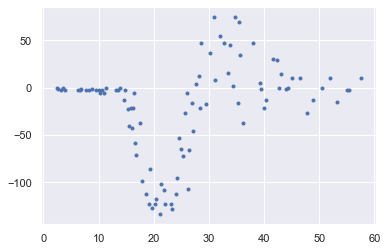

In [47]:
data = np.loadtxt("motor.dat")
X = data[:, 0][:, None]
Y = data[:, 1]
plt.plot(X, Y, '.')

**Solution:**
<br></br><br></br><br></br><br></br><br></br>

### Part B - Hierarchical Priors 

Specify priors on the model hyperparameters and estimate the full joint posterior over the model weights and model hyperparameters. At a minimum, specify appropriate priors for the  prior precision of the weights vector, and the likelihood noise. Use the estimated posterior to get the posterior predictive distribution over test inputs. 

**Solution:**
<br></br><br></br><br></br><br></br><br></br>

### Part C - Heteroscedastic regression

So far, throughout this course, you have seen likelihood models that assume that the noise level $\sigma$ is independent of the input $x$. This is known as *homoscedasticity* - the assumption that errors in a regression model are indepedent of the inputs. Consider the following likelihood model with input dependent noise:
$$
y \sim \mathcal{N} ( y | \mathbf{w}^T \phi(x) , \sigma(x)^2),
$$
where the likelihood noise depends on the input. 
Approximate $\log \sigma$ as a GLM of your choice - $\log \sigma = \phi_{\sigma}(x)^T \mathbf{w_{\sigma}}$ to model the dependence of the likelihood noise to the input. 
Develop the `PyMC3` model to express the heteroscedastic model and estimate the joint posterior over all parameters and hyperparameters. 
The parameters that you need to infer will include the weights of the output GLM $\mathbf{w}$, the weights of the noise GLM model $\mathbf{w}_{\sigma}$, the precision over $\mathbf{w}$ and the precision over $\mathbf{w}_{\sigma}$ and any additional hyperparameters you might have in your model.
Use the estimated posterior to show the posterior predictive distribution over test inputs. 

**Solution:**
<br></br><br></br><br></br><br></br><br></br>